In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import astropy.cosmology as apc
from sphviewer.tools import QuickView
from sphviewer.tools import Blend

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [5]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [6]:
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
TdayTotalStars = sim['SnapNumber_128/PartType4/ParticleIDs'][()] # need this first
I = np.identity(3) # and this

In [7]:
def getGroupAndSnap(gal, cen):
    """
    get me the members that belong to the group that the galaxy belongs before the groups.
    """
    
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+cen)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    first = 0
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][idd]
        groupC = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        
        if group != groupC and first==0:
            first = 1
        elif group != groupC and first==1:
            TheSnap = snap
            IDD = idd
            TheGroup = group
            break
    
    return TheSnap, IDD, TheGroup

In [8]:
# a try

TheSnap, IDD, TheGroup = getGroupAndSnap(4338, 4337)
TheSnap, IDD, TheGroup

(102, 5026, 4754)

In [9]:
#ok, that part apparently works
def getCompanions(gal, cen):
    TheSnap, IDD, TheGroup = getGroupAndSnap(gal, cen)
    
    AllGal = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(TheSnap)][()]
    iGroup = np.where(AllGal==TheGroup)[0]
    
    BCG = iGroup[0]
    isBCG = False
    
    if iGroup[0] == IDD:
        isBCG = True
        
    iare = np.where(iGroup!=IDD)[0]
    listGal = iGroup[iare]
    
    Masses, MassesTot = [], 0
    
    DMmass = sim['SnapNumber_{}/Header/MassTable'.format(TheSnap)][1]
    
    DmOff = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(TheSnap)][IDD].astype('int')
    GasOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(TheSnap)][IDD].astype('int')
    StarOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(TheSnap)][IDD].astype('int')
    
    GasMass = sim['SnapNumber_{}/PartType0/Masses'.format(TheSnap)][GasOff[0]:GasOff[1]]
    StarMass = sim['SnapNumber_{}/PartType4/Masses'.format(TheSnap)][StarOff[0]:StarOff[1]]
    
    GalMass = DMmass*(DmOff[1]-DmOff[0])+np.sum(GasMass)+np.sum(StarMass)
    
    for gal in listGal:
        DmOff = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(TheSnap)][gal].astype('int')
        GasOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(TheSnap)][gal].astype('int')
        StarOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(TheSnap)][gal].astype('int')
    
        GasMass = sim['SnapNumber_{}/PartType0/Masses'.format(TheSnap)][GasOff[0]:GasOff[1]]
        StarMass = sim['SnapNumber_{}/PartType4/Masses'.format(TheSnap)][StarOff[0]:StarOff[1]]
    
        TMass = DMmass*(DmOff[1]-DmOff[0])+np.sum(GasMass)+np.sum(StarMass)
        Masses.append(TMass)
        MassesTot += TMass
        
    Masses = np.array(Masses)/MassesTot
    
    how50, how75, how95 = 0, 0, 0
    how25, how100 = 0, Masses.size
    
    Msum = 0
    for i, mm in enumerate(Masses):
        Msum += mm
        if Msum>=.25 and how25==0:
            how25 = i+1
        if Msum>=.5 and how50==0:
            how50 = i+1
        if Msum>=.75 and how75==0:
            how75 = i+1
        if Msum>=.9 and how95==0:
            how95 = i+1
    
    if isBCG:
        return isBCG, GalMass/MassesTot, how25 ,how50, how75, how95, how100, Masses
    else:
        return listGal[0], GalMass/MassesTot, how25, how50, how75, how95, how100 ,Masses

In [10]:
isBCG, GalMassR, how25, how50, how75, how95, how100, Masses = getCompanions(4338, 4337)
isBCG, GalMassR, how25, how50, how75, how95, how100

(True, 3.4124123410329594, 1, 1, 2, 6, 19)

In [11]:
isBCG, GalMassR, how25, how50, how75, how95, how100, Masses = getCompanions(4339, 4337)
isBCG, GalMassR, how25, how50, how75, how95, how100

(True, 14.44075186139519, 1, 1, 1, 1, 4)

In [12]:
isBCG, GalMassR, how25, how50, how75, how95, how100, Masses= getCompanions(4341, 4337)
isBCG, GalMassR, how25, how50, how75, how95, how100

(5026, 0.1315886303743211, 1, 1, 1, 2, 19)

In [13]:
isBCG, GalMassR, how25, how50, how75, how95, how100, Masses = getCompanions(4343, 4337)
isBCG, GalMassR, how25, how50, how75, how95, how100

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars


(True, inf, 0, 0, 0, 0, 0)

In [14]:
isBCG, GalMassR, how25, how50, how75, how95, how100, Masses = getCompanions(4470, 4469)
isBCG, GalMassR, how25, how50, how75, how95, how100

(True, 3.6082670127265914, 1, 2, 4, 9, 51)

In [15]:
isBCG, GalMassR, how25, how50, how75, how95, how100, Masses = getCompanions(4471, 4469)
isBCG, GalMassR, how25, how50, how75, how95, how100

(True, 5.26913690629406, 1, 1, 2, 9, 43)

In [16]:
isBCG, GalMassR, how25, how50, how75, how95, how100, Masses = getCompanions(4473, 4469)
isBCG, GalMassR, how25, how50, how75, how95, how100

(0, 0.11119673895538393, 1, 1, 1, 2, 51)

In [17]:
isBCG, GalMassR, how25, how50, how75, how95, how100, Massess = getCompanions(4474, 4469)
isBCG, GalMassR, how25, how50, how75, how95, how100

(44, 0.1250777935270516, 1, 1, 1, 1, 43)

In [18]:
# lets see the ones that are not bcgs of their groups, those are
# 4341, with 5026
# 4473, with 0
# 4474, with 44

TheSnap1, IDD1, TheGroup1 = getGroupAndSnap(4341, 4337)
TheSnap2, IDD2, TheGroup2 = getGroupAndSnap(4473, 4469)
TheSnap3, IDD3, TheGroup3 = getGroupAndSnap(4474, 4469)

uid1 = int(TheSnap1*1e6+5026)
stree1 = networkx.dfs_tree(trees, str(uid1))
mtree1 = get_main_branch_unique_ids(stree1, str(uid1))

uid2 = int(TheSnap2*1e6+0)
stree2 = networkx.dfs_tree(trees, str(uid2))
mtree2 = get_main_branch_unique_ids(stree2, str(uid2))

uid3 = int(TheSnap3*1e6+44)
stree3 = networkx.dfs_tree(trees, str(uid3))
mtree3 = get_main_branch_unique_ids(stree3, str(uid3))

mtree1[-1], mtree2[-1], mtree3[-1]

('128004338', '128004470', '128004471')

In [19]:
# and now do some time travel, i don't know if stars only or what, i think or what
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()]

def getAllLastP_IDs(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            # now we keep only the ones inside r_optical
            
#             rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
            
#             posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
#             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            
#             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
#             rr = np.sqrt(xx**2+yy**2+zz**2)
            
#             ik = np.where(rr<rop)[0]
            
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             tempIds = tempIds[ik]
            
            Idlist.extend(list(tempIds))
#             zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
#             zlist.extend([zs]*tempIds.size)
            

    Idlist = np.array(Idlist)
#     zlist = np.array(zlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
#     zlist = zlist[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
#     rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
#     posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
#     xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
#     rr = np.sqrt(xx**2+yy**2+zz**2)
            
#     ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
#     TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
#     SurvIds_ = TdayTotalIDs[IndexT_]
#     iidex = np.in1d(Idlist, SurvIds_)
#     iidex_ = np.where(iidex)[0]
#     zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]

#     is1 = np.argsort(SurvIds_) # the target
#     is2 = np.argsort(Idlist_)

#     zorder = np.zeros(IndexT_.size)
#     zorder[is1] = zlist_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
#     posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0]
#     IndexT_near_ = IndexT_near[icut2]
        
#     zorder_ = zorder[icut2]

    IndexT_near_ = IndexT_near
        
#     zorder_ = zorder
#     NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near_]
    IDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IndexT_near_]

    return IDs#, zorder_

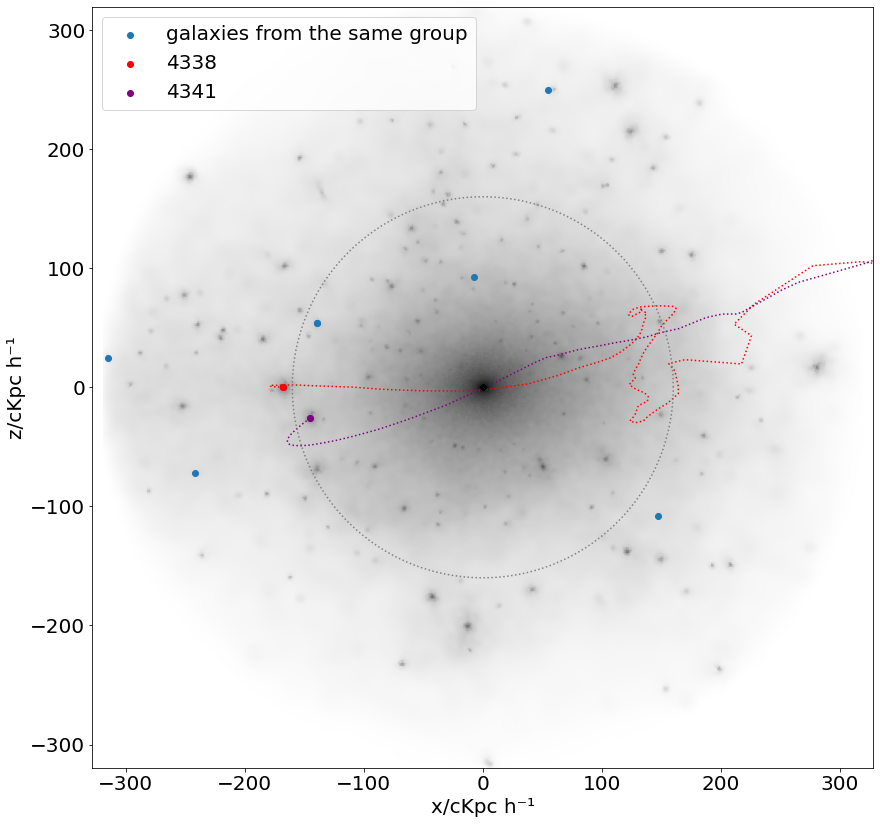

In [20]:
# lets plots this, perzonalized. because it is just 4 of them, 4338, 4339, 4470 and 4471, the rest are satellites
# or are not in groups, that is, lets see.

# firts, the rot matrix.

gal, cen = 4338, 4337
companion = 4341

posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal - velCen
pos = posGal - posCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

# there, now get the position of the galaxies that are part of the same original group at z=0

TheSnap, IDD, TheGroup = getGroupAndSnap(gal, cen)
    
AllGal = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(TheSnap)][()]
iGroup = np.where(AllGal==TheGroup)[0]

iare = np.where(iGroup!=IDD)[0]
listGal = iGroup[iare]

posZ0 = []

for s in listGal:
    uid = int(TheSnap*1e6+s)
    stree = networkx.dfs_tree(trees, str(uid))
    mtree = get_main_branch_unique_ids(stree, str(uid))
    
    last = mtree[-1]
    snap128, iddT = split_unique_id(int(last))
    if snap128 == 128:
        tpos = sim['SnapNumber_128/SubGroups/SubGroupPos'][iddT]
        posZ0.append(tpos-posCen)
        
posComp = sim['SnapNumber_128/SubGroups/SubGroupPos'][companion]
posC = posComp - posCen

# the orbits, that

ui = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(ui))
mtree = get_main_branch_unique_ids(stree, str(ui))

uiC = int(128*1e6+companion)
streeC = networkx.dfs_tree(trees, str(uiC))
mtreeC = get_main_branch_unique_ids(streeC, str(uiC))

uiCen = int(128*1e6+cen)
streeCen = networkx.dfs_tree(trees, str(uiCen))
mtreeCen = get_main_branch_unique_ids(streeCen, str(uiCen))


orG, orC = [], []

for m, mC, mCen in zip(mtree, mtreeC, mtreeCen):
    snapi, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
    snapCen, iddCen = split_unique_id(int(mCen))
    
    posT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][idd]
    posTC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddC]
    posTCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddCen]
    
    orG.append(posT-posTCen)
    orC.append(posTC-posTCen)
    
orG, orC = np.array(orG), np.array(orC)

# and all the DM

group = sim['SnapNumber_128/SubGroups/GroupNumber'][gal]
R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

DMpos = sim['SnapNumber_128/PartType1/Coordinates'][()]
X, Y, Z = DMpos[:,0] - posCen[0], DMpos[:,1] - posCen[1], DMpos[:,2] - posCen[2]
r = np.sqrt(X**2.+Y**2.+Z**2.)

ii = np.where(r<2*R200)
X, Y, Z = X[ii], Y[ii], Z[ii]

# ok, lets rotate all

rotPZ0 = []
for p in posZ0:
    dV = np.matmul(RM, p)
    rotPZ0.append(dV)
    
rotPZ0 = np.array(rotPZ0)

Xr, Yr, Zr = [], [], []
for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xr.append(dV[0])
    Yr.append(dV[1])
    Zr.append(dV[2])
    
Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

rotCen = np.matmul(RM, pos)
rotComp = np.matmul(RM, posC)

rotOrG, rotOrC = [], []
for rG, rC in zip(orG, orC):
    dG = np.matmul(RM, rG)
    dC = np.matmul(RM, rC)
    
    rotOrG.append(dG)
    rotOrC.append(dC)
    
rotOrG, rotOrC = np.array(rotOrG), np.array(rotOrC)
    
# and the plot

newP = np.array([Yr, Xr, Zr]).T

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r')

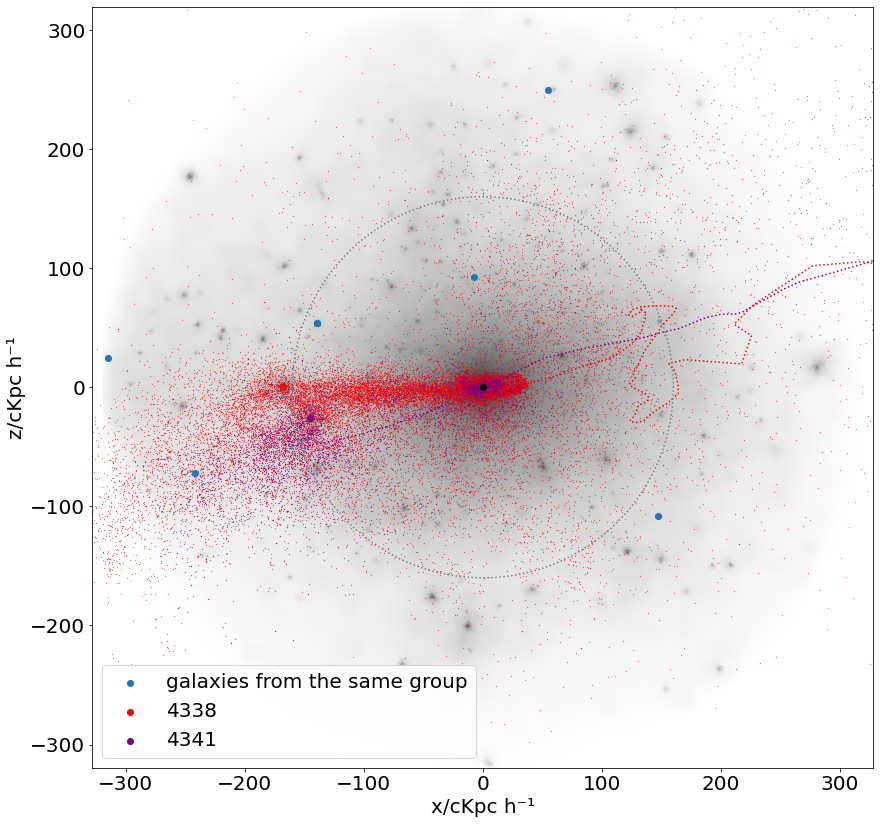

In [21]:
IDsgal = getAllLastP_IDs(gal, cen)
IDscomp = getAllLastP_IDs(companion, cen)

notIDs = np.isin(TdayTotalIDs, IDsgal)
notIDs_ = np.where(notIDs)[0]
NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][notIDs_]
Xgal, Ygal, Zgal = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

notIDsC = np.isin(TdayTotalIDs, IDscomp)
notIDsC_ = np.where(notIDsC)[0]
NearCoordC = sim['SnapNumber_128/PartType0/Coordinates'][notIDsC_]
Xcomp, Ycomp, Zcomp = NearCoordC[:,0] - posCen[0], NearCoordC[:,1] - posCen[1], NearCoordC[:,2] - posCen[2]


Xgalr, Ygalr, Zgalr = [], [], []
for x, y, z in zip(Xgal, Ygal, Zgal):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xgalr.append(dV[0])
    Ygalr.append(dV[1])
    Zgalr.append(dV[2])
    
Xgalr, Ygalr, Zgalr = np.array(Xgalr), np.array(Ygalr), np.array(Zgalr)

Xcompr, Ycompr, Zcompr = [], [], []
for x, y, z in zip(Xcomp, Ycomp, Zcomp):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xcompr.append(dV[0])
    Ycompr.append(dV[1])
    Zcompr.append(dV[2])
    
Xcompr, Ycompr, Zcompr = np.array(Xcompr), np.array(Ycompr), np.array(Zcompr)

# iap, to plot.

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')


pl.scatter(Ygalr, Xgalr, s=0.05, color='red', zorder=-100)
pl.scatter(Ycompr, Xcompr, s=0.05, color='purple', zorder=-100)

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r', zorder=-200)

In [20]:
# and now for multiple snapshots

gal, cen = 4338, 4337
companion = 4341


posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal - velCen
pos = posGal - posCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

group = sim['SnapNumber_128/SubGroups/GroupNumber'][gal]
R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]


TheSnap, IDD, TheGroup = getGroupAndSnap(gal, cen)

AllGal = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(TheSnap)][()]
iGroup = np.where(AllGal==TheGroup)[0]

iare = np.where(iGroup!=IDD)[0]
listGal = iGroup[iare]

GalsATZ0 = []
galTress = []

for s in listGal:
    uid = int(TheSnap*1e6+s)
    stree = networkx.dfs_tree(trees, str(uid))
    mtree = get_main_branch_unique_ids(stree, str(uid))
    
    last = mtree[-1]
    snap128, iddT = split_unique_id(int(last))
    if snap128 == 128:
        GalsATZ0.append(iddT)
#         mtree.reverse()
        neWstree = networkx.dfs_tree(trees, str(last))
        neWmtree = get_main_branch_unique_ids(neWstree, str(last))
        galTress.append(neWmtree)
        
GalsATZ0 = np.array(GalsATZ0)

# the orbits, that

ui = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(ui))
mtree = get_main_branch_unique_ids(stree, str(ui))

uiC = int(128*1e6+companion)
streeC = networkx.dfs_tree(trees, str(uiC))
mtreeC = get_main_branch_unique_ids(streeC, str(uiC))

uiCen = int(128*1e6+cen)
streeCen = networkx.dfs_tree(trees, str(uiCen))
mtreeCen = get_main_branch_unique_ids(streeCen, str(uiCen))

orG, orC = [], []

count = 0
for m, mC, mCen in zip(mtree, mtreeC, mtreeCen):
    snapi, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
    snapCen, iddCen = split_unique_id(int(mCen))
    
    posT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][idd]
    posTC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddC]
    posTCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddCen]
    
    orG.append(posT-posTCen)
    orC.append(posTC-posTCen)
    r = np.sqrt(np.sum((posT-posTCen)**2))
    if r<=3*R200:
        count += 1
    
orG, orC = np.array(orG), np.array(orC)

IDsgal = getAllLastP_IDs(gal, cen)
IDscomp = getAllLastP_IDs(companion, cen)


for i in range(count):
    id_galT = mtree[i]
    id_cenT = mtreeCen[i]
    id_compT = mtreeC[i]
    
    snap, galT = split_unique_id(int(id_galT))
    snapCen, cenT = split_unique_id(int(id_cenT))
    snapC, compT = split_unique_id(int(id_compT))
    
    if snap!=126:
        continue
    
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][galT]
    posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][cenT]

    pos = posGal - posCen

    posComp = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][compT]
    posC = posComp - posCen

    # and all the DM

#     DMpos = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][()]
#     X, Y, Z = DMpos[:,0] - posCen[0], DMpos[:,1] - posCen[1], DMpos[:,2] - posCen[2]
#     r = np.sqrt(X**2.+Y**2.+Z**2.)

#     ii = np.where(r<2*R200)
#     X, Y, Z = X[ii], Y[ii], Z[ii]

    # the position of the other galaxies
    posZ0 = []
    
    for mt in galTress:
        gm = mt[i]
        snapn, gtt = split_unique_id(int(gm))
        tpos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gtt]
        posZ0.append(tpos-posCen)
        
    posZ0 = np.array(posZ0)
    
    # and lost particles
    
    SnapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]
    
    notIDs = np.isin(SnapTotalIDs, IDsgal)
    notIDs_ = np.where(notIDs)[0]
    NearCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][notIDs_]
    Xgal, Ygal, Zgal = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

    notIDsC = np.isin(SnapTotalIDs, IDscomp)
    notIDsC_ = np.where(notIDsC)[0]
    NearCoordC = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][notIDsC_]
    Xcomp, Ycomp, Zcomp = NearCoordC[:,0] - posCen[0], NearCoordC[:,1] - posCen[1], NearCoordC[:,2] - posCen[2]

    # ok, lets rotate all

    rotPZ0 = []
    for p in posZ0:
        dV = np.matmul(RM, p)
        rotPZ0.append(dV)

    rotPZ0 = np.array(rotPZ0)

#     Xr, Yr, Zr = [], [], []
#     for x, y, z in zip(X, Y, Z):
#         dV = np.matmul(RM, np.array([x, y, z]))

#         Xr.append(dV[0])
#         Yr.append(dV[1])
#         Zr.append(dV[2])

#     Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

    rotCen = np.matmul(RM, pos)
    rotComp = np.matmul(RM, posC)

    rotOrG, rotOrC = [], []
    for rG, rC in zip(orG, orC):
        dG = np.matmul(RM, rG)
        dC = np.matmul(RM, rC)

        rotOrG.append(dG)
        rotOrC.append(dC)

    rotOrG, rotOrC = np.array(rotOrG), np.array(rotOrC)
    
    Xgalr, Ygalr, Zgalr = [], [], []
    for x, y, z in zip(Xgal, Ygal, Zgal):
        dV = np.matmul(RM, np.array([x, y, z]))

        Xgalr.append(dV[0])
        Ygalr.append(dV[1])
        Zgalr.append(dV[2])

    Xgalr, Ygalr, Zgalr = np.array(Xgalr), np.array(Ygalr), np.array(Zgalr)

    Xcompr, Ycompr, Zcompr = [], [], []
    for x, y, z in zip(Xcomp, Ycomp, Zcomp):
        dV = np.matmul(RM, np.array([x, y, z]))

        Xcompr.append(dV[0])
        Ycompr.append(dV[1])
        Zcompr.append(dV[2])

    Xcompr, Ycompr, Zcompr = np.array(Xcompr), np.array(Ycompr), np.array(Zcompr)
    
    # and the plot
    
#     newP = np.array([Yr, Zr, Xr]).T
    
    #fig, ax = pl.subplots(figsize=(28,14))

    fig = pl.figure(figsize=(28, 14))
    
    pl.subplot(1, 2, 1)
    
    tr200 = np.linspace(0, 2*np.pi, 360)
    xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

    pl.scatter(rotPZ0[:,1], rotPZ0[:,2], label='galaxies from the same group')
    pl.scatter(rotCen[1], rotCen[2], label='{}'.format(gal), color='red')
    pl.scatter(rotComp[1], rotComp[2], label='{}'.format(companion), color='purple')

    pl.plot(rotOrG[:,1], rotOrG[:,2], ls=':', color='red')
    pl.plot(rotOrC[:,1], rotOrC[:,2], ls=':', color='purple')

    pl.scatter(Ygalr, Zgalr, s=0.05, color='red', zorder=-100)
    pl.scatter(Ycompr, Zcompr, s=0.05, color='purple', zorder=-100)

    pl.scatter(0., 0., color='black')

    pl.plot(xr200, yr200, ls=':', color='grey')
    pl.plot(0, 0,  marker='o', ls=' ', color='black')

    znow = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    
    tnow = Cosmo.lookback_time(znow).value
    tnow = np.float(np.int(tnow*100))/100.

    pl.text(-2*R200+10, -2*R200+10, '$t\,=\,'+str(tnow)+'\,\,Gyrs\,\,h^{-1}$')
    
#     pl.legend(loc=2)

    pl.xlabel('x/cKpc h⁻¹')
    pl.ylabel('y/cKpc h⁻¹')

    pl.axis('equal')

#     qv = QuickView(newP, r='infinity', plot=False)
#     qv.imshow(cmap='gist_gray_r', zorder=-200)
    
    pl.xlim(-2*R200, 2*R200)
    pl.ylim(-2*R200, 2*R200)
    
    pl.subplot(1, 2, 2)
    
#     newP = np.array([Yr, Xr, Zr]).T
    
    tr200 = np.linspace(0, 2*np.pi, 360)
    xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

    pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
    pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
    pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

    pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
    pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')

    pl.scatter(Ygalr, Xgalr, s=0.05, color='red', zorder=-100)
    pl.scatter(Ycompr, Xcompr, s=0.05, color='purple', zorder=-100)

    pl.scatter(0., 0., color='black')

    pl.plot(xr200, yr200, ls=':', color='grey')
    pl.plot(0, 0,  marker='o', ls=' ', color='black')

#     znow = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    
#     tnow = Cosmo.lookback_time(znow).value
#     tnow = np.float(np.int(tnow*100))/100.

#     pl.text(-2*R200+10, -2*R200+10, '$t\,=\,'+str(tnow)+'\,\,Gyrs\,\,h^{-1}$')

    pl.legend(loc=2)

    pl.xlabel('x/cKpc h⁻¹')
    pl.ylabel('z/cKpc h⁻¹')

    pl.axis('equal')

#     qv = QuickView(newP, r='infinity', plot=False)
#     qv.imshow(cmap='gist_gray_r', zorder=-200)
    
    pl.xlim(-2*R200, 2*R200)
    pl.ylim(-2*R200, 2*R200)
    
    nuu = str(count-i).zfill(3)
    fig.savefig('OFe_test/OrbitOGroupXYZ_{}_{}.png'.format(gal, nuu))

    pl.close()
    

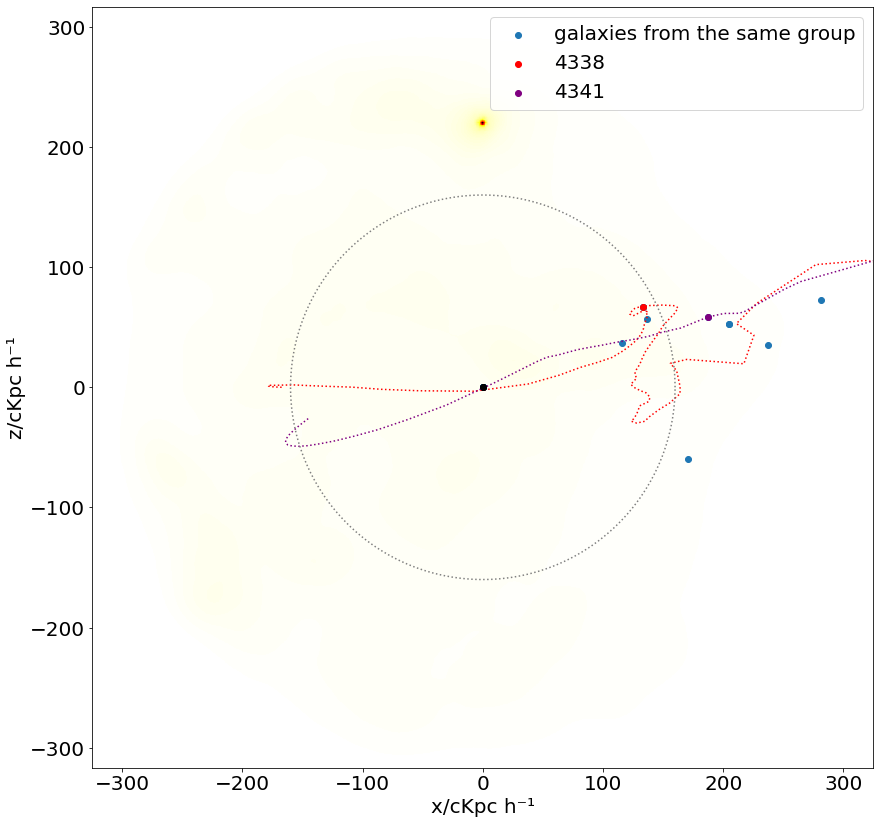

In [23]:
# and with the gas

Gaspos = sim['SnapNumber_128/PartType0/Coordinates'][()]
X, Y, Z = Gaspos[:,0] - posCen[0], Gaspos[:,1] - posCen[1], Gaspos[:,2] - posCen[2]
r = np.sqrt(X**2.+Y**2.+Z**2.)

ii = np.where(r<2*R200)[0]
X, Y, Z = X[ii], Y[ii], Z[ii]

# ok, lets rotate all

Xr, Yr, Zr = [], [], []
for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xr.append(dV[0])
    Yr.append(dV[1])
    Zr.append(dV[2])
    
Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

# and the plot

newP = np.array([Yr, Xr, Zr]).T

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='hot_r')

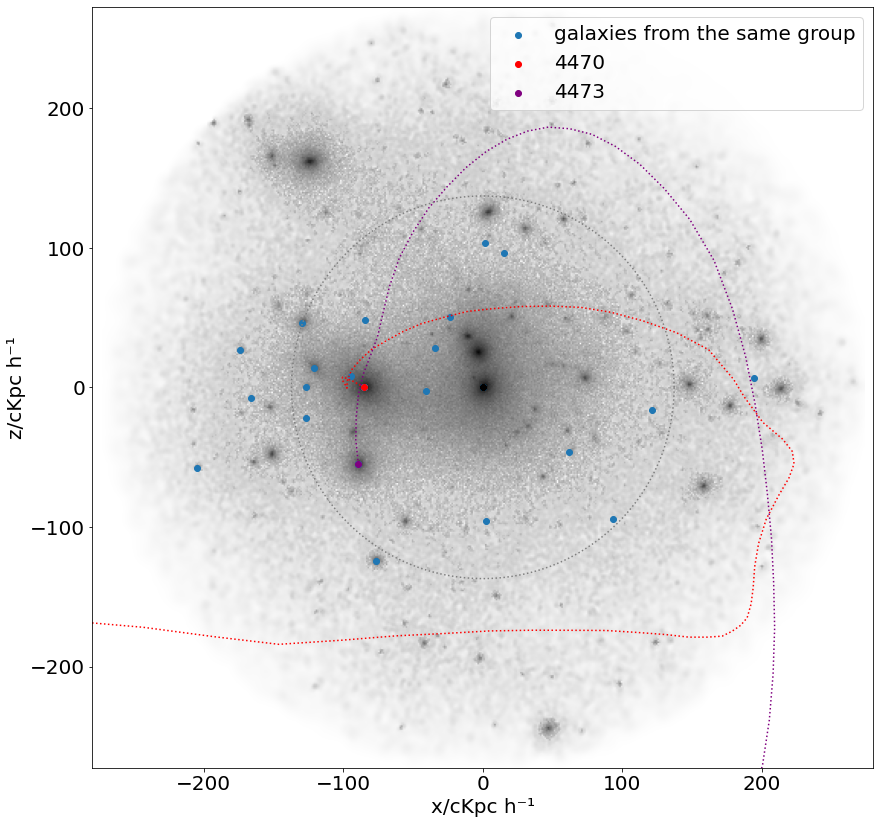

In [24]:
gal, cen = 4470, 4469
companion = 4473

posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal - velCen
pos = posGal - posCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

# there, now get the position of the galaxies that are part of the same original group at z=0

TheSnap, IDD, TheGroup = getGroupAndSnap(gal, cen)
    
AllGal = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(TheSnap)][()]
iGroup = np.where(AllGal==TheGroup)[0]

iare = np.where(iGroup!=IDD)[0]
listGal = iGroup[iare]

posZ0 = []

for s in listGal:
    uid = int(TheSnap*1e6+s)
    try:
        stree = networkx.dfs_tree(trees, str(uid))
        mtree = get_main_branch_unique_ids(stree, str(uid))
    
        last = mtree[-1]
        snap128, iddT = split_unique_id(int(last))
        if snap128 == 128:
            tpos = sim['SnapNumber_128/SubGroups/SubGroupPos'][iddT]
            posZ0.append(tpos-posCen)
    except:
        pass
        
posComp = sim['SnapNumber_128/SubGroups/SubGroupPos'][companion]
posC = posComp - posCen

# the orbits, that

ui = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(ui))
mtree = get_main_branch_unique_ids(stree, str(ui))

uiC = int(128*1e6+companion)
streeC = networkx.dfs_tree(trees, str(uiC))
mtreeC = get_main_branch_unique_ids(streeC, str(uiC))

uiCen = int(128*1e6+cen)
streeCen = networkx.dfs_tree(trees, str(uiCen))
mtreeCen = get_main_branch_unique_ids(streeCen, str(uiCen))

orG, orC = [], []

for m, mC, mCen in zip(mtree, mtreeC, mtreeCen):
    snapi, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
    snapCen, iddCen = split_unique_id(int(mCen))
    
    posT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][idd]
    posTC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddC]
    posTCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddCen]
    
    orG.append(posT-posTCen)
    orC.append(posTC-posTCen)
    
orG, orC = np.array(orG), np.array(orC)

# and all the DM

group = sim['SnapNumber_128/SubGroups/GroupNumber'][gal]
R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

DMpos = sim['SnapNumber_128/PartType1/Coordinates'][()]
X, Y, Z = DMpos[:,0] - posCen[0], DMpos[:,1] - posCen[1], DMpos[:,2] - posCen[2]
r = np.sqrt(X**2.+Y**2.+Z**2.)

ii = np.where(r<2*R200)
X, Y, Z = X[ii], Y[ii], Z[ii]

# ok, lets rotate all

rotPZ0 = []
for p in posZ0:
    dV = np.matmul(RM, p)
    rotPZ0.append(dV)
    
rotPZ0 = np.array(rotPZ0)

Xr, Yr, Zr = [], [], []
for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xr.append(dV[0])
    Yr.append(dV[1])
    Zr.append(dV[2])
    
Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

rotCen = np.matmul(RM, pos)
rotComp = np.matmul(RM, posC)

rotOrG, rotOrC = [], []
for rG, rC in zip(orG, orC):
    dG = np.matmul(RM, rG)
    dC = np.matmul(RM, rC)
    
    rotOrG.append(dG)
    rotOrC.append(dC)
    
rotOrG, rotOrC = np.array(rotOrG), np.array(rotOrC)
    
# and the plot

newP = np.array([Yr, Xr, Yr]).T

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r')

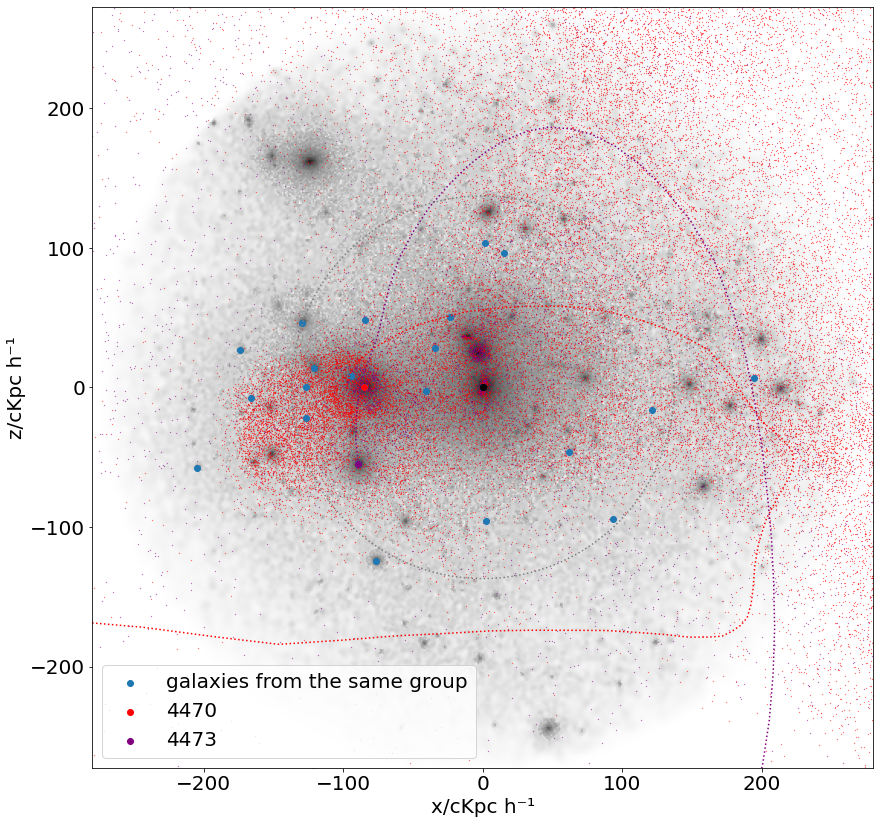

In [25]:
IDsgal = getAllLastP_IDs(gal, cen)
IDscomp = getAllLastP_IDs(companion, cen)

notIDs = np.isin(TdayTotalIDs, IDsgal)
notIDs_ = np.where(notIDs)[0]
NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][notIDs_]
Xgal, Ygal, Zgal = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

notIDsC = np.isin(TdayTotalIDs, IDscomp)
notIDsC_ = np.where(notIDsC)[0]
NearCoordC = sim['SnapNumber_128/PartType0/Coordinates'][notIDsC_]
Xcomp, Ycomp, Zcomp = NearCoordC[:,0] - posCen[0], NearCoordC[:,1] - posCen[1], NearCoordC[:,2] - posCen[2]


Xgalr, Ygalr, Zgalr = [], [], []
for x, y, z in zip(Xgal, Ygal, Zgal):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xgalr.append(dV[0])
    Ygalr.append(dV[1])
    Zgalr.append(dV[2])
    
Xgalr, Ygalr, Zgalr = np.array(Xgalr), np.array(Ygalr), np.array(Zgalr)

Xcompr, Ycompr, Zcompr = [], [], []
for x, y, z in zip(Xcomp, Ycomp, Zcomp):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xcompr.append(dV[0])
    Ycompr.append(dV[1])
    Zcompr.append(dV[2])
    
Xcompr, Ycompr, Zcompr = np.array(Xcompr), np.array(Ycompr), np.array(Zcompr)

# iap, to plot.

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')

pl.scatter(Ygalr, Xgalr, s=0.05, color='red', zorder=-100)
pl.scatter(Ycompr, Xcompr, s=0.05, color='purple', zorder=-100)

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r', zorder=-200)

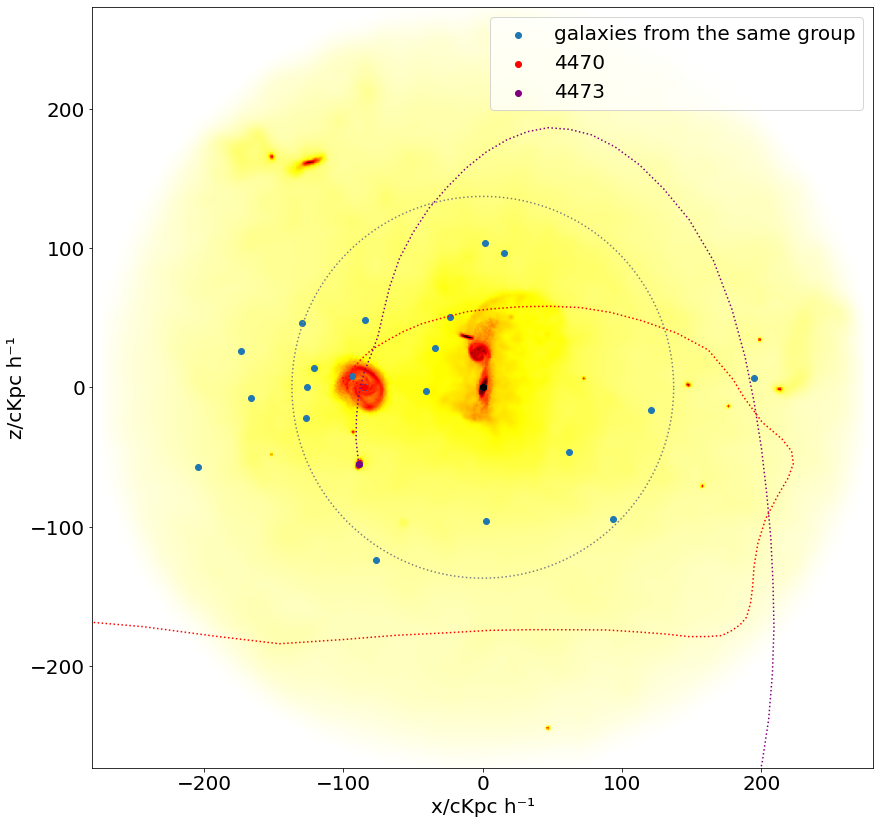

In [26]:
# and with the gas

Gaspos = sim['SnapNumber_128/PartType0/Coordinates'][()]
X, Y, Z = Gaspos[:,0] - posCen[0], Gaspos[:,1] - posCen[1], Gaspos[:,2] - posCen[2]
r = np.sqrt(X**2.+Y**2.+Z**2.)

ii = np.where(r<2*R200)[0]
X, Y, Z = X[ii], Y[ii], Z[ii]

# ok, lets rotate all

Xr, Yr, Zr = [], [], []
for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xr.append(dV[0])
    Yr.append(dV[1])
    Zr.append(dV[2])
    
Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

# and the plot

newP = np.array([Yr, Xr, Zr]).T

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='hot_r')

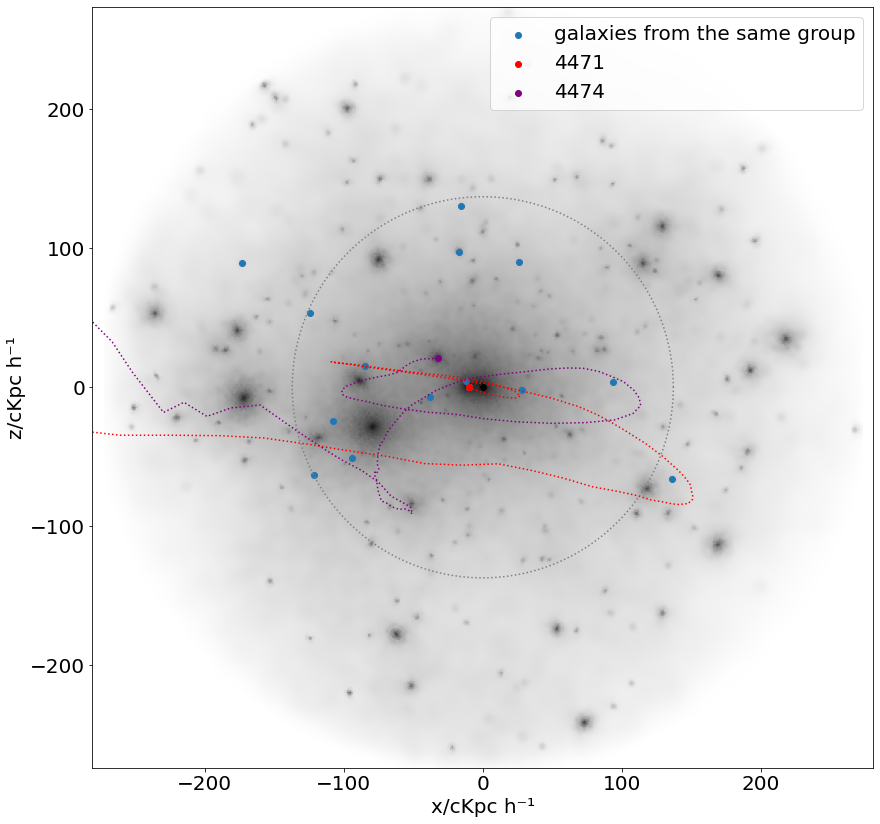

In [27]:
gal, cen = 4471, 4469
companion = 4474

posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal - velCen
pos = posGal - posCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

# there, now get the position of the galaxies that are part of the same original group at z=0

TheSnap, IDD, TheGroup = getGroupAndSnap(gal, cen)
    
AllGal = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(TheSnap)][()]
iGroup = np.where(AllGal==TheGroup)[0]

iare = np.where(iGroup!=IDD)[0]
listGal = iGroup[iare]

posZ0 = []

for s in listGal:
    uid = int(TheSnap*1e6+s)
    try:
        stree = networkx.dfs_tree(trees, str(uid))
        mtree = get_main_branch_unique_ids(stree, str(uid))
    
        last = mtree[-1]
        snap128, iddT = split_unique_id(int(last))
        if snap128 == 128:
            tpos = sim['SnapNumber_128/SubGroups/SubGroupPos'][iddT]
            posZ0.append(tpos-posCen)
    except:
        pass
        
posComp = sim['SnapNumber_128/SubGroups/SubGroupPos'][companion]
posC = posComp - posCen

# the orbits, that

ui = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(ui))
mtree = get_main_branch_unique_ids(stree, str(ui))

uiC = int(128*1e6+companion)
streeC = networkx.dfs_tree(trees, str(uiC))
mtreeC = get_main_branch_unique_ids(streeC, str(uiC))

uiCen = int(128*1e6+cen)
streeCen = networkx.dfs_tree(trees, str(uiCen))
mtreeCen = get_main_branch_unique_ids(streeCen, str(uiCen))

orG, orC = [], []

for m, mC, mCen in zip(mtree, mtreeC, mtreeCen):
    snapi, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
    snapCen, iddCen = split_unique_id(int(mCen))
    
    posT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][idd]
    posTC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddC]
    posTCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddCen]
    
    orG.append(posT-posTCen)
    orC.append(posTC-posTCen)
    
orG, orC = np.array(orG), np.array(orC)

# and all the DM

group = sim['SnapNumber_128/SubGroups/GroupNumber'][gal]
R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

DMpos = sim['SnapNumber_128/PartType1/Coordinates'][()]
X, Y, Z = DMpos[:,0] - posCen[0], DMpos[:,1] - posCen[1], DMpos[:,2] - posCen[2]
r = np.sqrt(X**2.+Y**2.+Z**2.)

ii = np.where(r<2*R200)
X, Y, Z = X[ii], Y[ii], Z[ii]

# ok, lets rotate all

rotPZ0 = []
for p in posZ0:
    dV = np.matmul(RM, p)
    rotPZ0.append(dV)
    
rotPZ0 = np.array(rotPZ0)

Xr, Yr, Zr = [], [], []
for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xr.append(dV[0])
    Yr.append(dV[1])
    Zr.append(dV[2])
    
Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

rotCen = np.matmul(RM, pos)
rotComp = np.matmul(RM, posC)

rotOrG, rotOrC = [], []
for rG, rC in zip(orG, orC):
    dG = np.matmul(RM, rG)
    dC = np.matmul(RM, rC)
    
    rotOrG.append(dG)
    rotOrC.append(dC)
    
rotOrG, rotOrC = np.array(rotOrG), np.array(rotOrC)
    
# and the plot

newP = np.array([Yr, Xr, Zr]).T

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r')

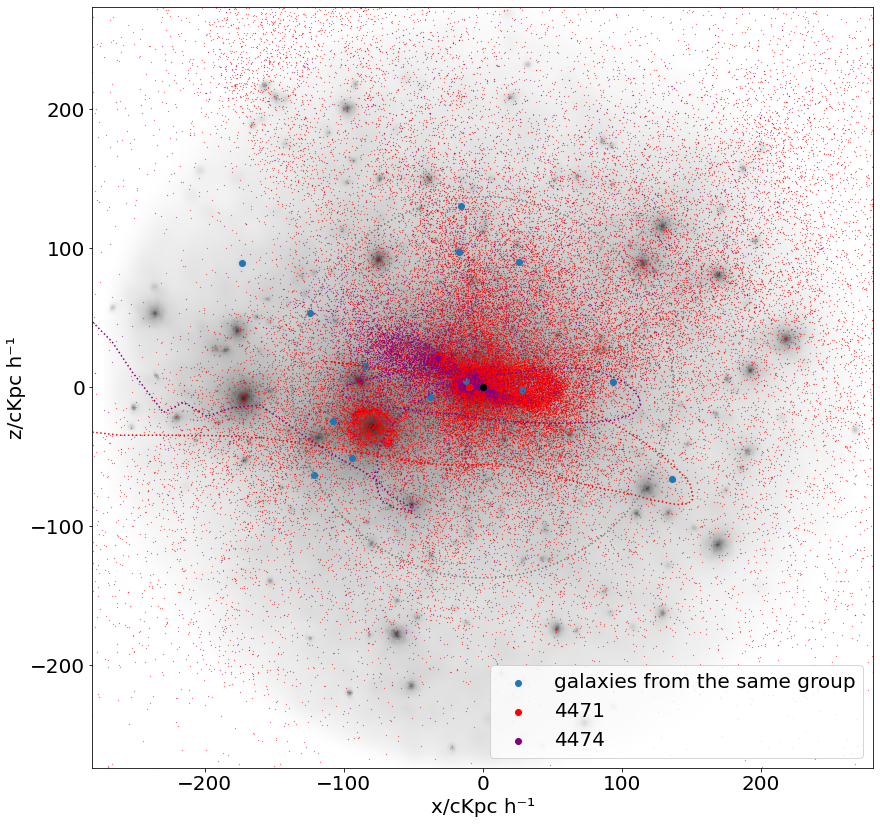

In [28]:
IDsgal = getAllLastP_IDs(gal, cen)
IDscomp = getAllLastP_IDs(companion, cen)

notIDs = np.isin(TdayTotalIDs, IDsgal)
notIDs_ = np.where(notIDs)[0]
NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][notIDs_]
Xgal, Ygal, Zgal = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

notIDsC = np.isin(TdayTotalIDs, IDscomp)
notIDsC_ = np.where(notIDsC)[0]
NearCoordC = sim['SnapNumber_128/PartType0/Coordinates'][notIDsC_]
Xcomp, Ycomp, Zcomp = NearCoordC[:,0] - posCen[0], NearCoordC[:,1] - posCen[1], NearCoordC[:,2] - posCen[2]


Xgalr, Ygalr, Zgalr = [], [], []
for x, y, z in zip(Xgal, Ygal, Zgal):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xgalr.append(dV[0])
    Ygalr.append(dV[1])
    Zgalr.append(dV[2])
    
Xgalr, Ygalr, Zgalr = np.array(Xgalr), np.array(Ygalr), np.array(Zgalr)

Xcompr, Ycompr, Zcompr = [], [], []
for x, y, z in zip(Xcomp, Ycomp, Zcomp):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xcompr.append(dV[0])
    Ycompr.append(dV[1])
    Zcompr.append(dV[2])
    
Xcompr, Ycompr, Zcompr = np.array(Xcompr), np.array(Ycompr), np.array(Zcompr)

# iap, to plot.

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')


pl.scatter(Ygalr, Xgalr, s=0.05, color='red', zorder=-100)
pl.scatter(Ycompr, Xcompr, s=0.05, color='purple', zorder=-100)

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r', zorder=-200)

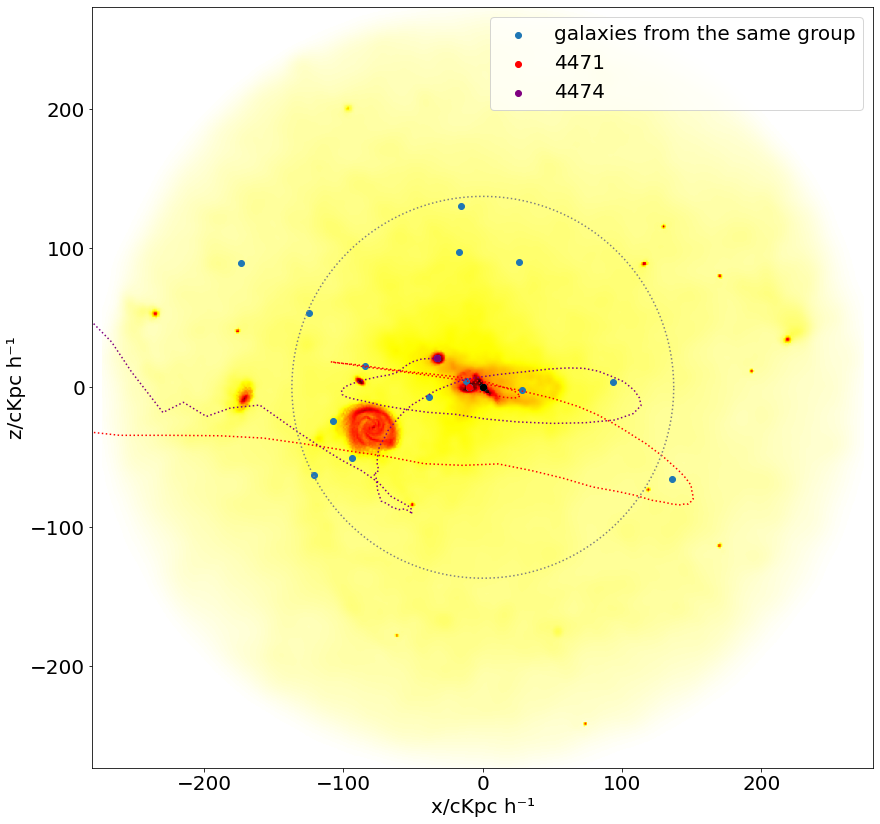

In [29]:
# and with the gas

Gaspos = sim['SnapNumber_128/PartType0/Coordinates'][()]
X, Y, Z = Gaspos[:,0] - posCen[0], Gaspos[:,1] - posCen[1], Gaspos[:,2] - posCen[2]
r = np.sqrt(X**2.+Y**2.+Z**2.)

ii = np.where(r<2*R200)[0]
X, Y, Z = X[ii], Y[ii], Z[ii]

# ok, lets rotate all

Xr, Yr, Zr = [], [], []
for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xr.append(dV[0])
    Yr.append(dV[1])
    Zr.append(dV[2])
    
Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

# and the plot

newP = np.array([Yr, Xr, Zr]).T

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='hot_r')

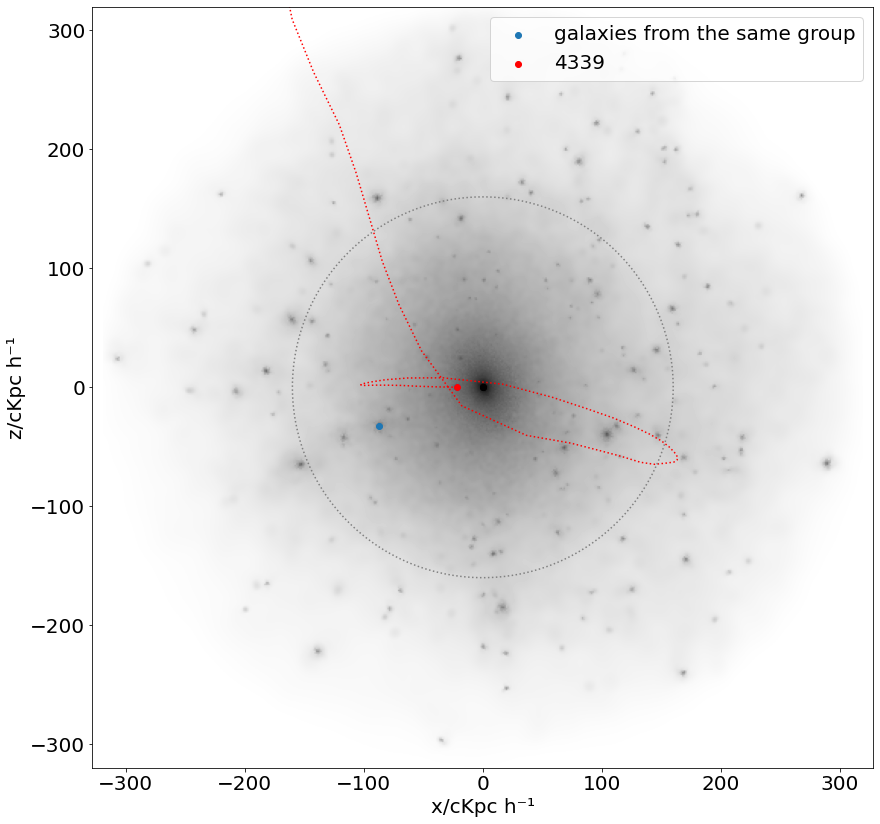

In [30]:
# and the solo one, this.

gal, cen = 4339, 4337

posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal - velCen
pos = posGal - posCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

# there, now get the position of the galaxies that are part of the same original group at z=0

TheSnap, IDD, TheGroup = getGroupAndSnap(gal, cen)
    
AllGal = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(TheSnap)][()]
iGroup = np.where(AllGal==TheGroup)[0]

iare = np.where(iGroup!=IDD)[0]
listGal = iGroup[iare]

posZ0 = []

for s in listGal:
    uid = int(TheSnap*1e6+s)
    try:
        stree = networkx.dfs_tree(trees, str(uid))
        mtree = get_main_branch_unique_ids(stree, str(uid))
    
        last = mtree[-1]
        snap128, iddT = split_unique_id(int(last))
        if snap128 == 128:
            tpos = sim['SnapNumber_128/SubGroups/SubGroupPos'][iddT]
            posZ0.append(tpos-posCen)
    except:
        pass
        
# the orbits, that

ui = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(ui))
mtree = get_main_branch_unique_ids(stree, str(ui))

uiCen = int(128*1e6+cen)
streeCen = networkx.dfs_tree(trees, str(uiCen))
mtreeCen = get_main_branch_unique_ids(streeCen, str(uiCen))

orG = []

for m, mCen in zip(mtree, mtreeCen):
    snapi, idd = split_unique_id(int(m))
    snapCen, iddCen = split_unique_id(int(mCen))
    
    posT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][idd]
    posTCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddCen]
    
    orG.append(posT-posTCen)
    
orG = np.array(orG)

# and all the DM

group = sim['SnapNumber_128/SubGroups/GroupNumber'][gal]
R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

DMpos = sim['SnapNumber_128/PartType1/Coordinates'][()]
X, Y, Z = DMpos[:,0] - posCen[0], DMpos[:,1] - posCen[1], DMpos[:,2] - posCen[2]
r = np.sqrt(X**2.+Y**2.+Z**2.)

ii = np.where(r<2*R200)
X, Y, Z = X[ii], Y[ii], Z[ii]

# ok, lets rotate all

rotPZ0 = []
for p in posZ0:
    dV = np.matmul(RM, p)
    rotPZ0.append(dV)
    
rotPZ0 = np.array(rotPZ0)

Xr, Yr, Zr = [], [], []
for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xr.append(dV[0])
    Yr.append(dV[1])
    Zr.append(dV[2])
    
Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

rotCen = np.matmul(RM, pos)

rotOrG = []
for rG in orG:
    dG = np.matmul(RM, rG)
    
    rotOrG.append(dG)
    
rotOrG = np.array(rotOrG)
    
# and the plot

newP = np.array([Yr, Xr, Zr]).T

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r')

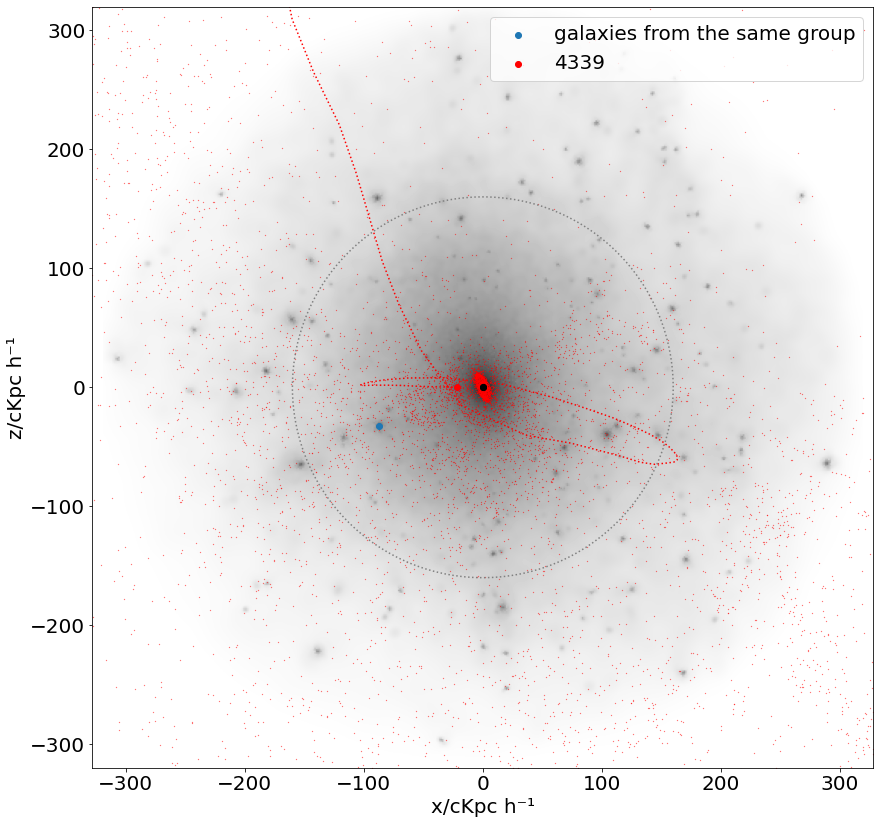

In [31]:
IDsgal = getAllLastP_IDs(gal, cen)

notIDs = np.isin(TdayTotalIDs, IDsgal)
notIDs_ = np.where(notIDs)[0]
NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][notIDs_]
Xgal, Ygal, Zgal = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]


Xgalr, Ygalr, Zgalr = [], [], []
for x, y, z in zip(Xgal, Ygal, Zgal):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xgalr.append(dV[0])
    Ygalr.append(dV[1])
    Zgalr.append(dV[2])
    
Xgalr, Ygalr, Zgalr = np.array(Xgalr), np.array(Ygalr), np.array(Zgalr)

# iap, to plot.

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')

pl.scatter(Ygalr, Xgalr, s=0.05, color='red', zorder=-100)

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r', zorder=-200)

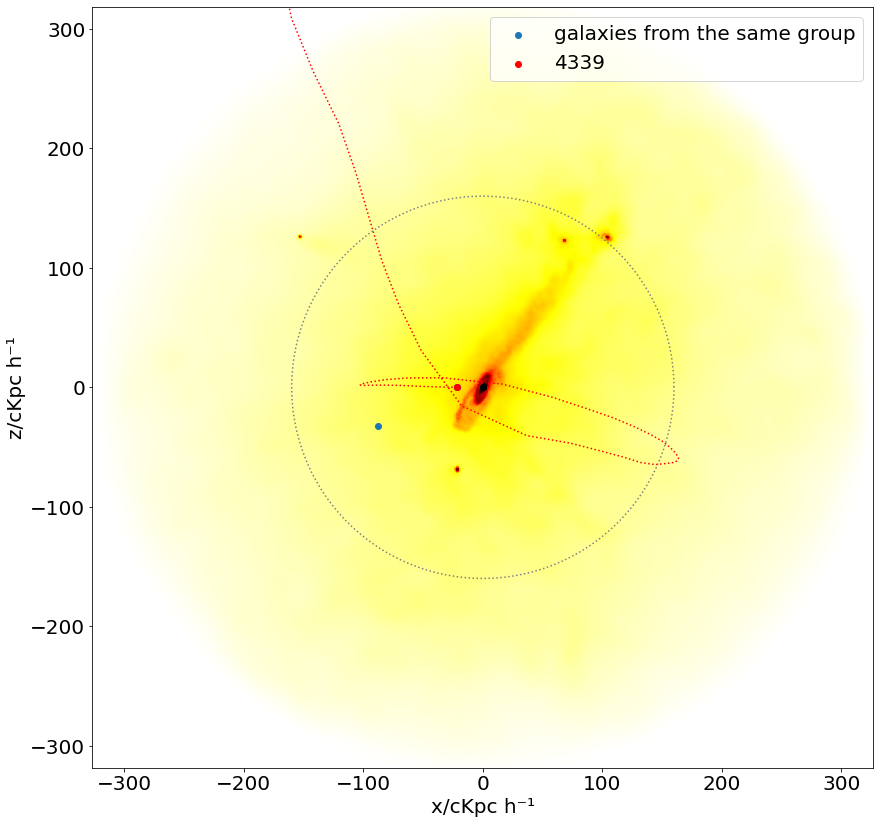

In [32]:
# and with the gas

Gaspos = sim['SnapNumber_128/PartType0/Coordinates'][()]
X, Y, Z = Gaspos[:,0] - posCen[0], Gaspos[:,1] - posCen[1], Gaspos[:,2] - posCen[2]
r = np.sqrt(X**2.+Y**2.+Z**2.)

ii = np.where(r<2*R200)[0]
X, Y, Z = X[ii], Y[ii], Z[ii]

# ok, lets rotate all

Xr, Yr, Zr = [], [], []
for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xr.append(dV[0])
    Yr.append(dV[1])
    Zr.append(dV[2])
    
Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

# and the plot

newP = np.array([Yr, Zr, Xr]).T

fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')

pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')

pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.legend(loc='best')

pl.xlabel('x/cKpc h⁻¹')
pl.ylabel('z/cKpc h⁻¹')

pl.axis('equal')

qv = QuickView(newP, r='infinity', plot=False)
qv.imshow(cmap='hot_r')

In [35]:
# and now for multiple snapshots

gal, cen = 4470, 4469
companion = 4473

posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal - velCen
pos = posGal - posCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f


group = sim['SnapNumber_128/SubGroups/GroupNumber'][gal]
R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

TheSnap, IDD, TheGroup = getGroupAndSnap(gal, cen)

AllGal = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(TheSnap)][()]
iGroup = np.where(AllGal==TheGroup)[0]

iare = np.where(iGroup!=IDD)[0]
listGal = iGroup[iare]

GalsATZ0 = []
galTress = []

for s in listGal:
    uid = int(TheSnap*1e6+s)
    try:
        stree = networkx.dfs_tree(trees, str(uid))
        mtree = get_main_branch_unique_ids(stree, str(uid))
    
        last = mtree[-1]
        snap128, iddT = split_unique_id(int(last))
        if snap128 == 128:
            GalsATZ0.append(iddT)
            #mtree.reverse()
            neWstree = networkx.dfs_tree(trees, str(last))
            neWmtree = get_main_branch_unique_ids(neWstree, str(last))
            galTress.append(neWmtree)
    except:
        pass
        
GalsATZ0 = np.array(GalsATZ0)

# the orbits, that

ui = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(ui))
mtree = get_main_branch_unique_ids(stree, str(ui))

uiC = int(128*1e6+companion)
streeC = networkx.dfs_tree(trees, str(uiC))
mtreeC = get_main_branch_unique_ids(streeC, str(uiC))

uiCen = int(128*1e6+cen)
streeCen = networkx.dfs_tree(trees, str(uiCen))
mtreeCen = get_main_branch_unique_ids(streeCen, str(uiCen))

orG, orC = [], []

count = 0
for m, mC, mCen in zip(mtree, mtreeC, mtreeCen):
    snapi, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
    snapCen, iddCen = split_unique_id(int(mCen))
    
    posT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][idd]
    posTC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddC]
    posTCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddCen]
    
    orG.append(posT-posTCen)
    orC.append(posTC-posTCen)
    r = np.sqrt(np.sum((posT-posTCen)**2))
    if r<=3*R200:
        count += 1

orG, orC = np.array(orG), np.array(orC)

IDsgal = getAllLastP_IDs(gal, cen)
IDscomp = getAllLastP_IDs(companion, cen)


for i in range(count):
    id_galT = mtree[i]
    id_cenT = mtreeCen[i]
    id_compT = mtreeC[i]
    
    snap, galT = split_unique_id(int(id_galT))
    snapCen, cenT = split_unique_id(int(id_cenT))
    snapC, compT = split_unique_id(int(id_compT))
    
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][galT]
    posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][cenT]

    pos = posGal - posCen

    posComp = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][compT]
    posC = posComp - posCen

    # and all the DM

#     DMpos = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][()]
#     X, Y, Z = DMpos[:,0] - posCen[0], DMpos[:,1] - posCen[1], DMpos[:,2] - posCen[2]
#     r = np.sqrt(X**2.+Y**2.+Z**2.)

#     ii = np.where(r<2*R200)
#     X, Y, Z = X[ii], Y[ii], Z[ii]

    # the position of the other galaxies
    posZ0 = []
    
    for mt in galTress:
        gm = mt[i]
        snapn, gtt = split_unique_id(int(gm))
        tpos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gtt]
        posZ0.append(tpos-posCen)
        
    posZ0 = np.array(posZ0)
    
    # and lost particles
    
    SnapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]
    
    notIDs = np.isin(SnapTotalIDs, IDsgal)
    notIDs_ = np.where(notIDs)[0]
    NearCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][notIDs_]
    Xgal, Ygal, Zgal = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

    notIDsC = np.isin(SnapTotalIDs, IDscomp)
    notIDsC_ = np.where(notIDsC)[0]
    NearCoordC = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][notIDsC_]
    Xcomp, Ycomp, Zcomp = NearCoordC[:,0] - posCen[0], NearCoordC[:,1] - posCen[1], NearCoordC[:,2] - posCen[2]

    # ok, lets rotate all

    rotPZ0 = []
    for p in posZ0:
        dV = np.matmul(RM, p)
        rotPZ0.append(dV)

    rotPZ0 = np.array(rotPZ0)

#     Xr, Yr, Zr = [], [], []
#     for x, y, z in zip(X, Y, Z):
#         dV = np.matmul(RM, np.array([x, y, z]))

#         Xr.append(dV[0])
#         Yr.append(dV[1])
#         Zr.append(dV[2])

#     Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

    rotCen = np.matmul(RM, pos)
    rotComp = np.matmul(RM, posC)

    rotOrG, rotOrC = [], []
    for rG, rC in zip(orG, orC):
        dG = np.matmul(RM, rG)
        dC = np.matmul(RM, rC)

        rotOrG.append(dG)
        rotOrC.append(dC)

    rotOrG, rotOrC = np.array(rotOrG), np.array(rotOrC)
    
    Xgalr, Ygalr, Zgalr = [], [], []
    for x, y, z in zip(Xgal, Ygal, Zgal):
        dV = np.matmul(RM, np.array([x, y, z]))

        Xgalr.append(dV[0])
        Ygalr.append(dV[1])
        Zgalr.append(dV[2])

    Xgalr, Ygalr, Zgalr = np.array(Xgalr), np.array(Ygalr), np.array(Zgalr)

    Xcompr, Ycompr, Zcompr = [], [], []
    for x, y, z in zip(Xcomp, Ycomp, Zcomp):
        dV = np.matmul(RM, np.array([x, y, z]))

        Xcompr.append(dV[0])
        Ycompr.append(dV[1])
        Zcompr.append(dV[2])

    Xcompr, Ycompr, Zcompr = np.array(Xcompr), np.array(Ycompr), np.array(Zcompr)
    
    # and the plot
    
    
    
#     newP = np.array([Yr, Zr, Xr]).T
    
    fig = pl.figure(figsize=(28,14))

    pl.subplot(1, 2, 1)
    
    tr200 = np.linspace(0, 2*np.pi, 360)
    xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

    pl.scatter(rotPZ0[:,1], rotPZ0[:,2], label='galaxies from the same group')
    pl.scatter(rotCen[1], rotCen[2], label='{}'.format(gal), color='red')
    pl.scatter(rotComp[1], rotComp[2], label='{}'.format(companion), color='purple')

    pl.plot(rotOrG[:,1], rotOrG[:,2], ls=':', color='red')
    pl.plot(rotOrC[:,1], rotOrC[:,2], ls=':', color='purple')

    pl.scatter(Ygalr, Zgalr, s=0.05, color='red', zorder=-100)
    pl.scatter(Ycompr, Zcompr, s=0.05, color='purple', zorder=-100)

    pl.scatter(0., 0., color='black')

    pl.plot(xr200, yr200, ls=':', color='grey')
    pl.plot(0, 0,  marker='o', ls=' ', color='black')
  
    znow = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    
    tnow = Cosmo.lookback_time(znow).value
    tnow = np.float(np.int(tnow*100))/100.

    pl.text(-2*R200+10, -2*R200+10, '$t\,=\,'+str(tnow)+'\,\,Gyrs\,\,h^{-1}$')
    
#     pl.legend(loc=2)

    pl.xlabel('x/cKpc h⁻¹')
    pl.ylabel('y/cKpc h⁻¹')

    pl.axis('equal')
    
    pl.xlim(-2*R200, 2*R200)
    pl.ylim(-2*R200, 2*R200)

#     qv = QuickView(newP, r='infinity', plot=False)
#     qv.imshow(cmap='gist_gray_r', zorder=-200)
    
    pl.subplot(1, 2, 2)
    
#     newP = np.array([Yr, Xr, Zr]).T
    
    tr200 = np.linspace(0, 2*np.pi, 360)
    xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

    pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
    pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
    pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

    pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
    pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')

    pl.scatter(Ygalr, Xgalr, s=0.05, color='red', zorder=-100)
    pl.scatter(Ycompr, Xcompr, s=0.05, color='purple', zorder=-100)

    pl.scatter(0., 0., color='black')

    pl.plot(xr200, yr200, ls=':', color='grey')
    pl.plot(0, 0,  marker='o', ls=' ', color='black')
#  
#     znow = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    
#     tnow = Cosmo.lookback_time(znow).value
#     tnow = np.float(np.int(tnow*100))/100.

#     pl.text(-2*R200+10, -2*R200+10, '$t\,=\,'+str(tnow)+'\,\,Gyrs\,\,h^{-1}$')
    
    pl.legend(loc=2)

    pl.xlabel('x/cKpc h⁻¹')
    pl.ylabel('z/cKpc h⁻¹')


    
    pl.axis('equal')
    
    pl.xlim(-2*R200, 2*R200)
    pl.ylim(-2*R200, 2*R200)
#     qv = QuickView(newP, r='infinity', plot=False)
#     qv.imshow(cmap='gist_gray_r', zorder=-200)
    
    nuu = str(count-i).zfill(3)
    fig.savefig('OFe_test/OrbitOGroupXYZ_{}_{}.png'.format(gal, nuu))

    pl.close()

In [36]:
# and now for multiple snapshots

gal, cen = 4471, 4469
companion = 4474

posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal - velCen
pos = posGal - posCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f


group = sim['SnapNumber_128/SubGroups/GroupNumber'][gal]
R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

TheSnap, IDD, TheGroup = getGroupAndSnap(gal, cen)

AllGal = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(TheSnap)][()]
iGroup = np.where(AllGal==TheGroup)[0]

iare = np.where(iGroup!=IDD)[0]
listGal = iGroup[iare]

GalsATZ0 = []
galTress = []

for s in listGal:
    uid = int(TheSnap*1e6+s)
    try:
        stree = networkx.dfs_tree(trees, str(uid))
        mtree = get_main_branch_unique_ids(stree, str(uid))
    
        last = mtree[-1]
        snap128, iddT = split_unique_id(int(last))
        if snap128 == 128:
            GalsATZ0.append(iddT)
            #mtree.reverse()
            neWstree = networkx.dfs_tree(trees, str(last))
            neWmtree = get_main_branch_unique_ids(neWstree, str(last))
            galTress.append(neWmtree)
    except:
        pass
        
GalsATZ0 = np.array(GalsATZ0)

# the orbits, that

ui = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(ui))
mtree = get_main_branch_unique_ids(stree, str(ui))

uiC = int(128*1e6+companion)
streeC = networkx.dfs_tree(trees, str(uiC))
mtreeC = get_main_branch_unique_ids(streeC, str(uiC))

uiCen = int(128*1e6+cen)
streeCen = networkx.dfs_tree(trees, str(uiCen))
mtreeCen = get_main_branch_unique_ids(streeCen, str(uiCen))

orG, orC = [], []

count = 0
for m, mC, mCen in zip(mtree, mtreeC, mtreeCen):
    snapi, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
    snapCen, iddCen = split_unique_id(int(mCen))
    
    posT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][idd]
    posTC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddC]
    posTCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddCen]
    
    orG.append(posT-posTCen)
    orC.append(posTC-posTCen)
    r = np.sqrt(np.sum((posT-posTCen)**2))
    if r<=3*R200:
        count += 1

orG, orC = np.array(orG), np.array(orC)

IDsgal = getAllLastP_IDs(gal, cen)
IDscomp = getAllLastP_IDs(companion, cen)


for i in range(count):
    id_galT = mtree[i]
    id_cenT = mtreeCen[i]
    id_compT = mtreeC[i]
    
    snap, galT = split_unique_id(int(id_galT))
    snapCen, cenT = split_unique_id(int(id_cenT))
    snapC, compT = split_unique_id(int(id_compT))
    
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][galT]
    posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][cenT]

    pos = posGal - posCen

    posComp = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][compT]
    posC = posComp - posCen

    # and all the DM

#     DMpos = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][()]
#     X, Y, Z = DMpos[:,0] - posCen[0], DMpos[:,1] - posCen[1], DMpos[:,2] - posCen[2]
#     r = np.sqrt(X**2.+Y**2.+Z**2.)

#     ii = np.where(r<2*R200)
#     X, Y, Z = X[ii], Y[ii], Z[ii]

    # the position of the other galaxies
    posZ0 = []
    
    for mt in galTress:
        gm = mt[i]
        snapn, gtt = split_unique_id(int(gm))
        tpos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gtt]
        posZ0.append(tpos-posCen)
        
    posZ0 = np.array(posZ0)
    
    # and lost particles
    
    SnapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]
    
    notIDs = np.isin(SnapTotalIDs, IDsgal)
    notIDs_ = np.where(notIDs)[0]
    NearCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][notIDs_]
    Xgal, Ygal, Zgal = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

    notIDsC = np.isin(SnapTotalIDs, IDscomp)
    notIDsC_ = np.where(notIDsC)[0]
    NearCoordC = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][notIDsC_]
    Xcomp, Ycomp, Zcomp = NearCoordC[:,0] - posCen[0], NearCoordC[:,1] - posCen[1], NearCoordC[:,2] - posCen[2]

    # ok, lets rotate all

    rotPZ0 = []
    for p in posZ0:
        dV = np.matmul(RM, p)
        rotPZ0.append(dV)

    rotPZ0 = np.array(rotPZ0)

#     Xr, Yr, Zr = [], [], []
#     for x, y, z in zip(X, Y, Z):
#         dV = np.matmul(RM, np.array([x, y, z]))

#         Xr.append(dV[0])
#         Yr.append(dV[1])
#         Zr.append(dV[2])

#     Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

    rotCen = np.matmul(RM, pos)
    rotComp = np.matmul(RM, posC)

    rotOrG, rotOrC = [], []
    for rG, rC in zip(orG, orC):
        dG = np.matmul(RM, rG)
        dC = np.matmul(RM, rC)

        rotOrG.append(dG)
        rotOrC.append(dC)

    rotOrG, rotOrC = np.array(rotOrG), np.array(rotOrC)
    
    Xgalr, Ygalr, Zgalr = [], [], []
    for x, y, z in zip(Xgal, Ygal, Zgal):
        dV = np.matmul(RM, np.array([x, y, z]))

        Xgalr.append(dV[0])
        Ygalr.append(dV[1])
        Zgalr.append(dV[2])

    Xgalr, Ygalr, Zgalr = np.array(Xgalr), np.array(Ygalr), np.array(Zgalr)

    Xcompr, Ycompr, Zcompr = [], [], []
    for x, y, z in zip(Xcomp, Ycomp, Zcomp):
        dV = np.matmul(RM, np.array([x, y, z]))

        Xcompr.append(dV[0])
        Ycompr.append(dV[1])
        Zcompr.append(dV[2])

    Xcompr, Ycompr, Zcompr = np.array(Xcompr), np.array(Ycompr), np.array(Zcompr)
    
    # and the plot
    
#     newP = np.array([Yr, Zr, Xr]).T
    
    fig = pl.figure(figsize=(28,14))

    pl.subplot(1, 2, 1)
    
    tr200 = np.linspace(0, 2*np.pi, 360)
    xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

    pl.scatter(rotPZ0[:,1], rotPZ0[:,2], label='galaxies from the same group')
    pl.scatter(rotCen[1], rotCen[2], label='{}'.format(gal), color='red')
    pl.scatter(rotComp[1], rotComp[2], label='{}'.format(companion), color='purple')

    pl.plot(rotOrG[:,1], rotOrG[:,2], ls=':', color='red')
    pl.plot(rotOrC[:,1], rotOrC[:,2], ls=':', color='purple')

    pl.scatter(Ygalr, Zgalr, s=0.05, color='red', zorder=-100)
    pl.scatter(Ycompr, Zcompr, s=0.05, color='purple', zorder=-100)

    pl.scatter(0., 0., color='black')

    pl.plot(xr200, yr200, ls=':', color='grey')
    pl.plot(0, 0,  marker='o', ls=' ', color='black')
  
    znow = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    
    tnow = Cosmo.lookback_time(znow).value
    tnow = np.float(np.int(tnow*100))/100.

    pl.text(-2*R200+10, -2*R200+10, '$t\,=\,'+str(tnow)+'\,\,Gyrs\,\,h^{-1}$')
    
#     pl.legend(loc=2)

    pl.xlabel('x/cKpc h⁻¹')
    pl.ylabel('y/cKpc h⁻¹')

    pl.axis('equal')

    pl.xlim(-2*R200, 2*R200)
    pl.ylim(-2*R200, 2*R200)
    
#     qv = QuickView(newP, r='infinity', plot=False)
#     qv.imshow(cmap='gist_gray_r', zorder=-200)
    
    pl.subplot(1, 2, 2)
    
#     newP = np.array([Yr, Xr, Zr]).T
        
    tr200 = np.linspace(0, 2*np.pi, 360)
    xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

    pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
    pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
    pl.scatter(rotComp[1], rotComp[0], label='{}'.format(companion), color='purple')

    pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
    pl.plot(rotOrC[:,1], rotOrC[:,0], ls=':', color='purple')

    pl.scatter(Ygalr, Xgalr, s=0.05, color='red', zorder=-100)
    pl.scatter(Ycompr, Xcompr, s=0.05, color='purple', zorder=-100)

    pl.scatter(0., 0., color='black')

    pl.plot(xr200, yr200, ls=':', color='grey')
    pl.plot(0, 0,  marker='o', ls=' ', color='black')

    #
#     znow = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    
#     tnow = Cosmo.lookback_time(znow).value
#     tnow = np.float(np.int(tnow*100))/100.

#     pl.text(-2*R200+10, -2*R200+10, '$t\,=\,'+str(tnow)+'\,\,Gyrs\,\,h^{-1}$')
    
    pl.legend(loc=2)

    pl.xlabel('x/cKpc h⁻¹')
    pl.ylabel('z/cKpc h⁻¹')

    pl.axis('equal')

#     qv = QuickView(newP, r='infinity', plot=False)
#     qv.imshow(cmap='gist_gray_r', zorder=-200)
    
    pl.xlim(-2*R200, 2*R200)
    pl.ylim(-2*R200, 2*R200)
    
    nuu = str(count-i).zfill(3)
    fig.savefig('OFe_test/OrbitOGroupXYZ_{}_{}.png'.format(gal, nuu))

    pl.close()

In [37]:
# and now for multiple snapshots

gal, cen = 4339, 4337

posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal - velCen
pos = posGal - posCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f


group = sim['SnapNumber_128/SubGroups/GroupNumber'][gal]
R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

TheSnap, IDD, TheGroup = getGroupAndSnap(gal, cen)

AllGal = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(TheSnap)][()]
iGroup = np.where(AllGal==TheGroup)[0]

iare = np.where(iGroup!=IDD)[0]
listGal = iGroup[iare]

GalsATZ0 = []
galTress = []

for s in listGal:
    uid = int(TheSnap*1e6+s)
    try:
        stree = networkx.dfs_tree(trees, str(uid))
        mtree = get_main_branch_unique_ids(stree, str(uid))
    
        last = mtree[-1]
        snap128, iddT = split_unique_id(int(last))
        if snap128 == 128:
            GalsATZ0.append(iddT)
            #mtree.reverse()
            neWstree = networkx.dfs_tree(trees, str(last))
            neWmtree = get_main_branch_unique_ids(neWstree, str(last))
            galTress.append(neWmtree)
    except:
        pass
        
GalsATZ0 = np.array(GalsATZ0)

# the orbits

ui = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(ui))
mtree = get_main_branch_unique_ids(stree, str(ui))

uiCen = int(128*1e6+cen)
streeCen = networkx.dfs_tree(trees, str(uiCen))
mtreeCen = get_main_branch_unique_ids(streeCen, str(uiCen))

orG = []

count = 0
for m, mCen in zip(mtree, mtreeCen):
    snapi, idd = split_unique_id(int(m))
    snapCen, iddCen = split_unique_id(int(mCen))
    
    posT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][idd]
    posTCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddCen]
    
    orG.append(posT-posTCen)
    r = np.sqrt(np.sum((posT-posTCen)**2))
    if r<=3*R200:
        count += 1

orG = np.array(orG)

IDsgal = getAllLastP_IDs(gal, cen)

for i in range(count):
    id_galT = mtree[i]
    id_cenT = mtreeCen[i]
    
    snap, galT = split_unique_id(int(id_galT))
    snapCen, cenT = split_unique_id(int(id_cenT))
    
#     if snap==126:
#         continue
    
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][galT]
    posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][cenT]

    pos = posGal - posCen

    # and all the DM

#     DMpos = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][()]
#     X, Y, Z = DMpos[:,0] - posCen[0], DMpos[:,1] - posCen[1], DMpos[:,2] - posCen[2]
#     r = np.sqrt(X**2.+Y**2.+Z**2.)

#     ii = np.where(r<2*R200)
#     X, Y, Z = X[ii], Y[ii], Z[ii]

    # the position of the other galaxies
    posZ0 = []
    
    for mt in galTress:
        gm = mt[i]
        snapn, gtt = split_unique_id(int(gm))
        tpos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gtt]
        posZ0.append(tpos-posCen)
        
    posZ0 = np.array(posZ0)
    
    # and lost particles
    
    SnapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]
    
    notIDs = np.isin(SnapTotalIDs, IDsgal)
    notIDs_ = np.where(notIDs)[0]
    NearCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][notIDs_]
    Xgal, Ygal, Zgal = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

    # ok, lets rotate all

    rotPZ0 = []
    for p in posZ0:
        dV = np.matmul(RM, p)
        rotPZ0.append(dV)

    rotPZ0 = np.array(rotPZ0)

    Xr, Yr, Zr = [], [], []
    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RM, np.array([x, y, z]))

        Xr.append(dV[0])
        Yr.append(dV[1])
        Zr.append(dV[2])

    Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

    rotCen = np.matmul(RM, pos)

    rotOrG = []
    for rG in orG:
        dG = np.matmul(RM, rG)

        rotOrG.append(dG)

    rotOrG = np.array(rotOrG)
    
    Xgalr, Ygalr, Zgalr = [], [], []
    for x, y, z in zip(Xgal, Ygal, Zgal):
        dV = np.matmul(RM, np.array([x, y, z]))

        Xgalr.append(dV[0])
        Ygalr.append(dV[1])
        Zgalr.append(dV[2])

    Xgalr, Ygalr, Zgalr = np.array(Xgalr), np.array(Ygalr), np.array(Zgalr)

    # and the plot
    
#     newP = np.array([Yr, Zr, Xr]).T
    
    fig = pl.figure(figsize=(28,14))

    pl.subplot(1, 2, 1)
    
    tr200 = np.linspace(0, 2*np.pi, 360)
    xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

    pl.scatter(rotPZ0[:,1], rotPZ0[:,2], label='galaxies from the same group')
    pl.scatter(rotCen[1], rotCen[2], label='{}'.format(gal), color='red')

    pl.plot(rotOrG[:,1], rotOrG[:,2], ls=':', color='red')

    pl.scatter(Ygalr, Zgalr, s=0.05, color='red', zorder=-100)

    pl.scatter(0., 0., color='black')

    pl.plot(xr200, yr200, ls=':', color='grey')
    pl.plot(0, 0,  marker='o', ls=' ', color='black')
  
    znow = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    
    tnow = Cosmo.lookback_time(znow).value
    tnow = np.float(np.int(tnow*100))/100.

    pl.text(-2*R200+10, -2*R200+10, '$t\,=\,'+str(tnow)+'\,\,Gyrs\,\,h^{-1}$')
    
#     pl.legend(loc=2)

    pl.xlabel('x/cKpc h⁻¹')
    pl.ylabel('y/cKpc h⁻¹')

    pl.axis('equal')

#     qv = QuickView(newP, r='infinity', plot=False)
#     qv.imshow(cmap='gist_gray_r', zorder=-200)
    
    pl.xlim(-2*R200, 2*R200)
    pl.ylim(-2*R200, 2*R200)
    
    pl.subplot(1, 2, 2)
    
#     newP = np.array([Yr, Xr, Zr]).T
    
    tr200 = np.linspace(0, 2*np.pi, 360)
    xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

    pl.scatter(rotPZ0[:,1], rotPZ0[:,0], label='galaxies from the same group')
    pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')

    pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')

    pl.scatter(Ygalr, Xgalr, s=0.05, color='red', zorder=-100)

    pl.scatter(0., 0., color='black')

    pl.plot(xr200, yr200, ls=':', color='grey')
    pl.plot(0, 0,  marker='o', ls=' ', color='black')
#  
#     znow = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    
#     tnow = Cosmo.lookback_time(znow).value
#     tnow = np.float(np.int(tnow*100))/100.

#     pl.text(-2*R200+10, -2*R200+10, '$t\,=\,'+str(tnow)+'\,\,Gyrs\,\,h^{-1}$')
    
    pl.legend(loc=2)

    pl.xlabel('x/cKpc h⁻¹')
    pl.ylabel('z/cKpc h⁻¹')


    
    pl.axis('equal')

    pl.xlim(-2*R200, 2*R200)
    pl.ylim(-2*R200, 2*R200)
#     qv = QuickView(newP, r='infinity', plot=False)
#     qv.imshow(cmap='gist_gray_r', zorder=-200)
        
        
    nuu = str(count-i).zfill(3)
    fig.savefig('OFe_test/OrbitOGroupXYZ_{}_{}.png'.format(gal, nuu))

    pl.close()

In [ ]:
a = sim['SnapNumber_126/PartType1/Coordinates'][()]

In [20]:
gal, cen = 4470, 4469
companion1 = 4471
companion2 = 4473
companion3 = 4474

posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal - velCen
pos = posGal - posCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

group = sim['SnapNumber_128/SubGroups/GroupNumber'][gal]
R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

# the orbits, that

ui = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(ui))
mtree = get_main_branch_unique_ids(stree, str(ui))

uiC1 = int(128*1e6+companion1)
streeC1 = networkx.dfs_tree(trees, str(uiC1))
mtreeC1 = get_main_branch_unique_ids(streeC1, str(uiC1))

uiC2 = int(128*1e6+companion2)
streeC2 = networkx.dfs_tree(trees, str(uiC2))
mtreeC2 = get_main_branch_unique_ids(streeC2, str(uiC2))

uiC3 = int(128*1e6+companion3)
streeC3 = networkx.dfs_tree(trees, str(uiC3))
mtreeC3 = get_main_branch_unique_ids(streeC3, str(uiC3))

uiCen = int(128*1e6+cen)
streeCen = networkx.dfs_tree(trees, str(uiCen))
mtreeCen = get_main_branch_unique_ids(streeCen, str(uiCen))

orG, orC1, orC2, orC3 = [], [], [], []

count = 0
for m, mC1, mC2, mC3, mCen in zip(mtree, mtreeC1, mtreeC2, mtreeC3, mtreeCen):
    snapi, idd = split_unique_id(int(m))
    snapC1, iddC1 = split_unique_id(int(mC1))
    snapC2, iddC2 = split_unique_id(int(mC2))
    snapC3, iddC3 = split_unique_id(int(mC3))
    snapCen, iddCen = split_unique_id(int(mCen))
    
    posT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][idd]
    posTC1 = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddC1]
    posTC2 = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddC2]
    posTC3 = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddC3]
    posTCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapi)][iddCen]
    
    orG.append(posT-posTCen)
    orC1.append(posTC1-posTCen)
    orC2.append(posTC2-posTCen)
    orC3.append(posTC3-posTCen)
    
    r = np.sqrt(np.sum((posT-posTCen)**2))
    if r<=3*R200:
        count += 1

orG, orC1, orC2, orC3 = np.array(orG), np.array(orC1), np.array(orC2), np.array(orC3)

IDsgal = getAllLastP_IDs(gal, cen)
IDscomp = getAllLastP_IDs(companion1, cen)


#rotate the orbits
rotOrG, rotOrC1, rotOrC2, rotOrC3  = [], [], [], []
for rG, rC1, rC2, rC3 in zip(orG, orC1, orC2, orC3):
    dG = np.matmul(RM, rG)
    dC1 = np.matmul(RM, rC1)
    dC2 = np.matmul(RM, rC2)
    dC3 = np.matmul(RM, rC3)

    rotOrG.append(dG)
    rotOrC1.append(dC1)
    rotOrC2.append(dC2)
    rotOrC3.append(dC3)

rotOrG, rotOrC1, rotOrC2, rotOrC3 = np.array(rotOrG), np.array(rotOrC1), np.array(rotOrC2), np.array(rotOrC3)

for i in range(count):
    id_galT = mtree[i]
    id_cenT = mtreeCen[i]
    id_compT1 = mtreeC1[i]
    id_compT2 = mtreeC2[i]
    id_compT3 = mtreeC3[i]
    
    snap, galT = split_unique_id(int(id_galT))
    snapCen, cenT = split_unique_id(int(id_cenT))
    snapC1, compT1 = split_unique_id(int(id_compT1))
    snapC2, compT2 = split_unique_id(int(id_compT2))
    snapC3, compT3 = split_unique_id(int(id_compT3))
    
    if snap>=123:
        continue
    
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][galT]
    posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][cenT]

    pos = posGal - posCen

    posComp1 = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][compT1]
    posComp2 = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][compT2]
    posComp3 = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][compT3]
    posC1 = posComp1 - posCen
    posC2 = posComp2 - posCen
    posC3 = posComp3 - posCen
    
    # and lost particles
    
    SnapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]
    
    notIDs = np.isin(SnapTotalIDs, IDsgal)
    notIDs_ = np.where(notIDs)[0]
    NearCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][notIDs_]
    Xgal, Ygal, Zgal = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

    notIDsC = np.isin(SnapTotalIDs, IDscomp)
    notIDsC_ = np.where(notIDsC)[0]
    NearCoordC = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][notIDsC_]
    Xcomp, Ycomp, Zcomp = NearCoordC[:,0] - posCen[0], NearCoordC[:,1] - posCen[1], NearCoordC[:,2] - posCen[2]

    # ok, lets rotate all

    rotCen = np.matmul(RM, pos)
    rotComp1 = np.matmul(RM, posC1)
    rotComp2 = np.matmul(RM, posC2)
    rotComp3 = np.matmul(RM, posC3)
    
    Xgalr, Ygalr, Zgalr = [], [], []
    for x, y, z in zip(Xgal, Ygal, Zgal):
        dV = np.matmul(RM, np.array([x, y, z]))

        Xgalr.append(dV[0])
        Ygalr.append(dV[1])
        Zgalr.append(dV[2])

    Xgalr, Ygalr, Zgalr = np.array(Xgalr), np.array(Ygalr), np.array(Zgalr)

    Xcompr, Ycompr, Zcompr = [], [], []
    for x, y, z in zip(Xcomp, Ycomp, Zcomp):
        dV = np.matmul(RM, np.array([x, y, z]))

        Xcompr.append(dV[0])
        Ycompr.append(dV[1])
        Zcompr.append(dV[2])

    Xcompr, Ycompr, Zcompr = np.array(Xcompr), np.array(Ycompr), np.array(Zcompr)
    
    # and the plot
    
    fig = pl.figure(figsize=(28,14))

    pl.subplot(1, 2, 1)
    
    tr200 = np.linspace(0, 2*np.pi, 360)
    xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

    pl.scatter(rotCen[1], rotCen[2], label='{}'.format(gal), color='red')
    pl.scatter(rotComp1[1], rotComp1[2], label='{}'.format(companion1), color='purple')
    pl.scatter(rotComp2[1], rotComp2[2], label='{}'.format(companion2), color='green')
    pl.scatter(rotComp3[1], rotComp3[2], label='{}'.format(companion3), color='blue')
    
    pl.plot(rotOrG[:,1], rotOrG[:,2], ls=':', color='red')
    pl.plot(rotOrC1[:,1], rotOrC1[:,2], ls=':', color='purple')
    pl.plot(rotOrC2[:,1], rotOrC2[:,2], ls=':', color='green')
    pl.plot(rotOrC3[:,1], rotOrC3[:,2], ls=':', color='blue')
    
    pl.scatter(Ygalr, Zgalr, s=0.05, color='red', zorder=-100)
    pl.scatter(Ycompr, Zcompr, s=0.05, color='purple', zorder=-100)

    pl.scatter(0., 0., color='black')

    pl.plot(xr200, yr200, ls=':', color='grey')
    pl.plot(0, 0,  marker='o', ls=' ', color='black')
  
    znow = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    
    tnow = Cosmo.lookback_time(znow).value
    tnow = np.float(np.int(tnow*100))/100.

    pl.text(-2*R200+10, -2*R200+10, '$t\,=\,'+str(tnow)+'\,\,Gyrs\,\,h^{-1}$')

    pl.xlabel('x/cKpc h⁻¹')
    pl.ylabel('y/cKpc h⁻¹')

    pl.axis('equal')
    
    pl.xlim(-2*R200, 2*R200)
    pl.ylim(-2*R200, 2*R200)
    
    pl.subplot(1, 2, 2)
    
    tr200 = np.linspace(0, 2*np.pi, 360)
    xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

    pl.scatter(rotCen[1], rotCen[0], label='{}'.format(gal), color='red')
    pl.scatter(rotComp1[1], rotComp1[0], label='{}'.format(companion1), color='purple')
    pl.scatter(rotComp2[1], rotComp2[0], label='{}'.format(companion2), color='green')
    pl.scatter(rotComp3[1], rotComp3[0], label='{}'.format(companion3), color='blue')
    
    pl.plot(rotOrG[:,1], rotOrG[:,0], ls=':', color='red')
    pl.plot(rotOrC1[:,1], rotOrC1[:,0], ls=':', color='purple')
    pl.plot(rotOrC2[:,1], rotOrC2[:,0], ls=':', color='green')
    pl.plot(rotOrC3[:,1], rotOrC3[:,0], ls=':', color='blue')

    pl.scatter(Ygalr, Xgalr, s=0.05, color='red', zorder=-100)
    pl.scatter(Ycompr, Xcompr, s=0.05, color='purple', zorder=-100)

    pl.scatter(0., 0., color='black')

    pl.plot(xr200, yr200, ls=':', color='grey')
    pl.plot(0, 0,  marker='o', ls=' ', color='black')

    pl.legend(loc=2)

    pl.xlabel('x/cKpc h⁻¹')
    pl.ylabel('z/cKpc h⁻¹')
    
    pl.axis('equal')
    
    pl.xlim(-2*R200, 2*R200)
    pl.ylim(-2*R200, 2*R200)
    
    nuu = str(count-i).zfill(3)
    fig.savefig('OFe_test/OrbitOGroupXYZ_P_{}_{}.png'.format(gal, nuu))

    pl.close()